# Part2: Word2vec Implementation(Tensorflow)

## Import neccessary packages

In [2]:
import collections
import pickle
import math
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import random
import zipfile

import numpy as np
import urllib
import tensorflow as tf

In [2]:
inputfile = 'E:/clean_wiki.txt'

## Read from file, build vocabulary, and create word to indexes list

In [3]:
# generator function to read file with chunk size 100M
def read_file_by_chunk(file):
    with open(file, mode='r', encoding='utf-8') as f:
        while True:
            chunk = f.read(1024*1024*100)
            chunk = chunk.lower()
            if not chunk:
                return
            yield chunk.strip().split()

In [32]:
vocabulary_size = 100000
min_occurrence = 10
# create the dictionary and reversed dictionary with limitation to vocabulary size
def create_vocab(chunks,vocabulary_size):
    counter = collections.Counter()
    for chunk in chunks:
        counter.update(chunk)
    count = [('NAN', -1)]
    count.extend(counter.most_common(vocabulary_size-1))
    # Remove samples with less than 'min_occurrence' occurrences.
    for i in range(len(count) - 1, -1, -1):
        if count[i][1] < min_occurrence:
            count.pop(i)
        else:
        # stop when 'min_occurrence' is reached.
            break
    idx = 0
    dictionary = dict()
    with open('E:/Word2vec/vocab_300.txt', "w",encoding='utf-8') as f:
        for word, _ in count:
            # word_to_int
            dictionary[word] = idx
            f.write(word + "\n")
            idx += 1
        # int_to_word
        index_dict = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, index_dict             

In [33]:
# word to int pair list
def word_to_idx(chunks, dictionary):
    word_indexes = []
    unknown = 0
    for chunk in chunks:
        for word in chunk:
            if word in dictionary:
                word_indexes.append(dictionary[word])
            else:
                word_indexes.append(unknown)#index of all unknown(UNK) words
    return word_indexes

In [34]:
chunks = read_file_by_chunk(inputfile)

In [35]:
dictionary, reverse_dictionary = create_vocab(chunks, vocabulary_size)

In [36]:
chunks = read_file_by_chunk(inputfile)

In [37]:
word_indexes = word_to_idx(chunks, dictionary)

In [43]:
dictionary['british']

186

## Parameters

In [44]:
# Training Parameters
learning_rate = 0.1
batch_size = 128
num_steps = 5000000
display_step = 10000
eval_step = 200000

# Evaluation Parameters
eval_words = ['five', 'of', 'going', 'hardware', 'american', 'britain']

# Word2Vec Parameters
embedding_size = 300 # Dimension of the embedding vector
skip_window = 3 # Words to consider left and right
num_skips = 2 # Times to reuse an input to generate a label
num_sampled = 64 # Number of negative examples to sample

## Batch generation

In [45]:
data_index = 0
# Generate training batch for the skip-gram model
def next_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # get window size (words left and right + current one)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(word_indexes):
        data_index = 0
    buffer.extend(word_indexes[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(word_indexes):
            buffer.extend(word_indexes[0:span])
            data_index = span
        else:
            buffer.append(word_indexes[data_index])
            data_index += 1
    # Backtrack to avoid skipping words in the end of a batch
    data_index = (data_index + len(word_indexes) - span) % len(word_indexes)
    return batch, labels

In [46]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## Negative Sampling, optimizer, and normalization with evaluation

In [47]:
# Input data
X = tf.placeholder(tf.int32, shape=[None])
# Input label
Y = tf.placeholder(tf.int32, shape=[None, 1])

with tf.device('/cpu:0'):
    # Create the embedding variable (each row represent a word embedding vector)
    embedding = tf.Variable(tf.random_normal([vocabulary_size, embedding_size]))
    # Lookup the corresponding embedding vectors for each sample in X
    X_embed = tf.nn.embedding_lookup(embedding, X)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.random_normal([vocabulary_size, embedding_size]))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch
loss_op = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights,
                   biases=nce_biases,
                   labels=Y,
                   inputs=X_embed,
                   num_sampled=num_sampled,
                   num_classes=vocabulary_size))

In [48]:
# Define the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss_op)

In [49]:
# Evaluation
# Compute the cosine similarity between input data embedding and every embedding vectors
X_embed_norm = X_embed / tf.sqrt(tf.reduce_sum(tf.square(X_embed)))
# normalized embedding
embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
cosine_sim_op = tf.matmul(X_embed_norm, embedding_norm, transpose_b=True)

In [50]:
# Initialize the variables
init = tf.global_variables_initializer()

## Start training

In [52]:
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Testing data
    x_test = np.array([dictionary[w] for w in eval_words])

    average_loss = 0
    for step in range(1, num_steps + 1):
        # Get a new batch of data
        batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
        # Run training op
        _, loss = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
        average_loss += loss

        if step % display_step == 0 or step == 1:
            if step > 1:
                average_loss /= display_step
            print("Step " + str(step) + ", Average Loss= " + \
                  "{:.4f}".format(average_loss))
            average_loss = 0

        # Evaluation
        if step % eval_step == 0 or step == 1:
            print("Evaluation...")
            sim = sess.run(cosine_sim_op, feed_dict={X: x_test})
            for i in range(len(eval_words)):
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = '"%s" nearest neighbors:' % eval_words[i]
                for k in range(top_k):
                    log_str = '%s %s,' % (log_str, reverse_dictionary[nearest[k]])
                print(log_str)
    final_embeddings = embedding_norm.eval()
    np.save('E:/Word2vec/embeddings_wiki.npy', final_embeddings)

Step 1, Average Loss= 582.9850
Evaluation...
"five" nearest neighbors: unending, jkr, obligated, yoichi, darla, śląski, virtuosic, dancehall,
"of" nearest neighbors: funcinpec, mycobacteria, blossoming, screenshots, nitrogen, osx, armorial, groupie,
"going" nearest neighbors: printed, reshaped, expectations, volcanics, بن, steeple, recklinghausen, révolution,
"hardware" nearest neighbors: beaked, tietz, slumdog, doctorow, strafing, georg, kauri, arvin,
"american" nearest neighbors: reburied, detectable, hydrological, intoxicated, fernán, sdf, asanas, vectors,
"britain" nearest neighbors: kotayk, nafs, painstakingly, theravāda, furthers, convenience, embellish, garmsiri,
Step 10000, Average Loss= 272.7992
Step 20000, Average Loss= 153.9266
Step 30000, Average Loss= 110.9866
Step 40000, Average Loss= 84.4597
Step 50000, Average Loss= 70.1777
Step 60000, Average Loss= 61.6481
Step 70000, Average Loss= 52.5057
Step 80000, Average Loss= 46.0708
Step 90000, Average Loss= 42.8268
Step 100000,

## Plot embedding

In [53]:
from matplotlib import pylab
from sklearn.manifold import TSNE
%matplotlib inline

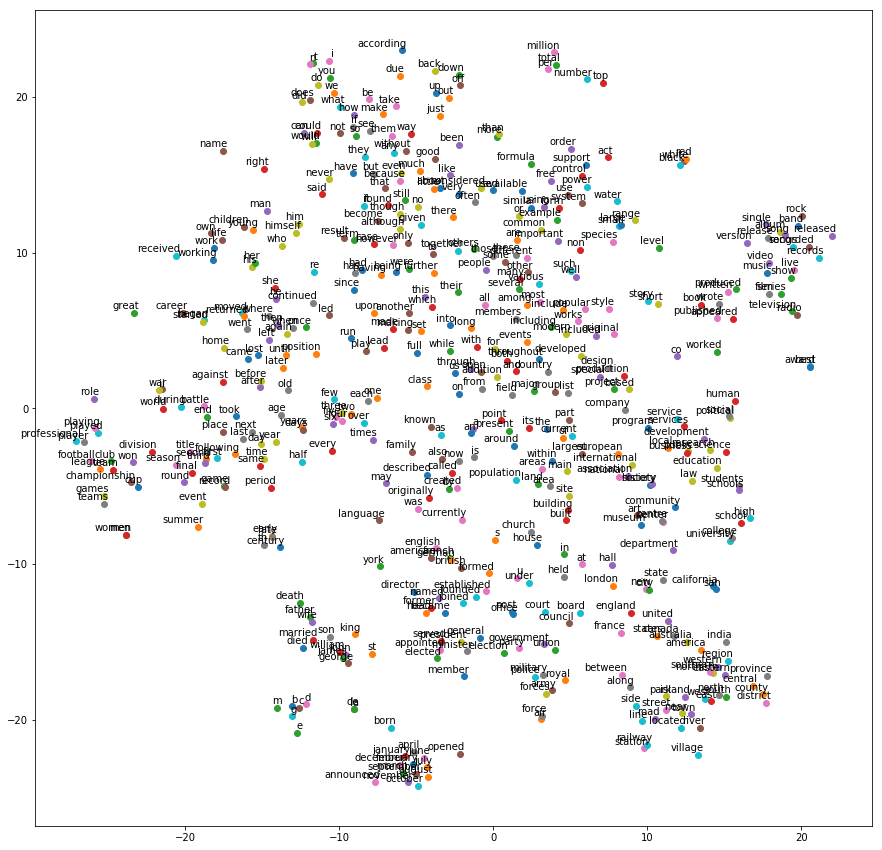

In [54]:
# plot the first 500 words from word embedding
num_points = 500
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)